In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from comet_ml import Experiment

# Local imports
sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import (delete_ds_store,plot_metrics,test,train,set_device,mean_std_finder,load_model)
from CBAM import ChannelAttention
from MBNV3 import MBNV3Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": ChannelAttention,
    "module_alias": "CAM",
    "data_path": "/Users/leo/Desktop/Thesis/data/vgg_200/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 200,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/756b301020504b3a9808c7f7dab2804e



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


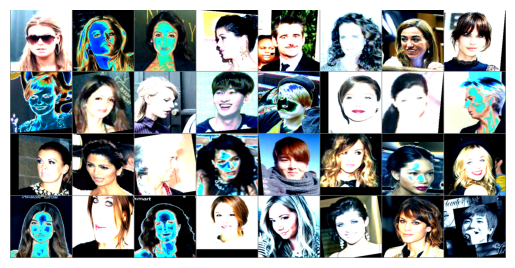

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
<class 'CBAM.ChannelAttention'> inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
Weights initialized for <class 'CBAM.ChannelAttention'> inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11] as well as the last layer.
Grads set to True for [1, 4, 5, 6, 7, 8, 9, 10, 11] and the last layer. (False for the rest)


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Desktop/Thesis/thesis_env/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                               [1, 3, 224, 224]     [1, 50]              --                   --                   --                   Partial
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   Partial
│    └─Conv2dNormActivation (0)                         [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   False
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 16, 112, 112]    (432)                [3, 3]               5,419,008            False
│    │    └─BatchNorm2d (1)                             [1, 16, 112, 112]    [1, 16, 112, 112]    (32)                 --                   32               

100%|██████████| 106/106 [00:09<00:00, 11.06it/s]


Epoch: 01 | Epoch Time: 2.0m 16s
	Train Loss: 3.867 | Train Acc: 3.17%
	 Val. Loss: 3.718 |  Val. Acc: 4.54%
Best Accuracy Achieved: 4.54% on epoch 01


100%|██████████| 106/106 [00:08<00:00, 11.87it/s]


Epoch: 02 | Epoch Time: 2.0m 8s
	Train Loss: 3.692 | Train Acc: 5.14%
	 Val. Loss: 3.532 |  Val. Acc: 7.99%
Best Accuracy Achieved: 7.99% on epoch 02


100%|██████████| 106/106 [00:09<00:00, 11.70it/s]


Epoch: 03 | Epoch Time: 2.0m 9s
	Train Loss: 3.559 | Train Acc: 7.82%
	 Val. Loss: 3.382 |  Val. Acc: 10.81%
Best Accuracy Achieved: 10.81% on epoch 03


100%|██████████| 106/106 [00:08<00:00, 11.93it/s]


Epoch: 04 | Epoch Time: 2.0m 13s
	Train Loss: 3.461 | Train Acc: 9.66%
	 Val. Loss: 3.297 |  Val. Acc: 12.74%
Best Accuracy Achieved: 12.74% on epoch 04


100%|██████████| 106/106 [00:08<00:00, 11.92it/s]


Epoch: 05 | Epoch Time: 2.0m 9s
	Train Loss: 3.371 | Train Acc: 11.10%
	 Val. Loss: 3.209 |  Val. Acc: 13.95%
Best Accuracy Achieved: 13.95% on epoch 05


100%|██████████| 106/106 [00:08<00:00, 11.93it/s]


Epoch: 06 | Epoch Time: 2.0m 10s
	Train Loss: 3.312 | Train Acc: 12.55%
	 Val. Loss: 3.165 |  Val. Acc: 15.05%
Best Accuracy Achieved: 15.05% on epoch 06


100%|██████████| 106/106 [00:08<00:00, 11.91it/s]


Epoch: 07 | Epoch Time: 2.0m 8s
	Train Loss: 3.274 | Train Acc: 13.30%
	 Val. Loss: 3.099 |  Val. Acc: 16.30%
Best Accuracy Achieved: 16.30% on epoch 07


100%|██████████| 106/106 [00:08<00:00, 11.99it/s]


Epoch: 08 | Epoch Time: 2.0m 12s
	Train Loss: 3.222 | Train Acc: 14.85%
	 Val. Loss: 3.090 |  Val. Acc: 16.75%
Best Accuracy Achieved: 16.75% on epoch 08


100%|██████████| 106/106 [00:08<00:00, 12.01it/s]


Epoch: 09 | Epoch Time: 2.0m 14s
	Train Loss: 3.187 | Train Acc: 15.11%
	 Val. Loss: 3.015 |  Val. Acc: 18.14%
Best Accuracy Achieved: 18.14% on epoch 09


100%|██████████| 106/106 [00:08<00:00, 11.82it/s]


Epoch: 10 | Epoch Time: 2.0m 17s
	Train Loss: 3.162 | Train Acc: 15.93%
	 Val. Loss: 2.983 |  Val. Acc: 18.71%
Best Accuracy Achieved: 18.71% on epoch 10


100%|██████████| 106/106 [00:08<00:00, 11.97it/s]


Epoch: 11 | Epoch Time: 2.0m 13s
	Train Loss: 3.130 | Train Acc: 16.86%
	 Val. Loss: 2.966 |  Val. Acc: 19.66%
Best Accuracy Achieved: 19.66% on epoch 11


100%|██████████| 106/106 [00:09<00:00, 11.47it/s]


Epoch: 12 | Epoch Time: 2.0m 22s
	Train Loss: 3.113 | Train Acc: 17.28%
	 Val. Loss: 2.983 |  Val. Acc: 19.24%


100%|██████████| 106/106 [00:09<00:00, 11.54it/s]


Epoch: 13 | Epoch Time: 2.0m 13s
	Train Loss: 3.077 | Train Acc: 17.68%
	 Val. Loss: 2.921 |  Val. Acc: 20.61%
Best Accuracy Achieved: 20.61% on epoch 13


100%|██████████| 106/106 [00:08<00:00, 12.71it/s]


Epoch: 14 | Epoch Time: 2.0m 4s
	Train Loss: 3.053 | Train Acc: 18.27%
	 Val. Loss: 2.882 |  Val. Acc: 21.76%
Best Accuracy Achieved: 21.76% on epoch 14


100%|██████████| 106/106 [00:08<00:00, 12.38it/s]


Epoch: 15 | Epoch Time: 2.0m 3s
	Train Loss: 3.025 | Train Acc: 18.89%
	 Val. Loss: 2.864 |  Val. Acc: 20.99%


100%|██████████| 106/106 [00:08<00:00, 12.41it/s]


Epoch: 16 | Epoch Time: 2.0m 9s
	Train Loss: 3.006 | Train Acc: 19.33%
	 Val. Loss: 2.849 |  Val. Acc: 21.67%


100%|██████████| 106/106 [00:08<00:00, 12.54it/s]


Epoch: 17 | Epoch Time: 2.0m 9s
	Train Loss: 2.994 | Train Acc: 19.45%
	 Val. Loss: 2.854 |  Val. Acc: 22.12%
Best Accuracy Achieved: 22.12% on epoch 17


100%|██████████| 106/106 [00:08<00:00, 12.27it/s]


Epoch: 18 | Epoch Time: 2.0m 6s
	Train Loss: 2.966 | Train Acc: 20.41%
	 Val. Loss: 2.805 |  Val. Acc: 23.78%
Best Accuracy Achieved: 23.78% on epoch 18


100%|██████████| 106/106 [00:08<00:00, 12.04it/s]


Epoch: 19 | Epoch Time: 2.0m 8s
	Train Loss: 2.953 | Train Acc: 20.79%
	 Val. Loss: 2.819 |  Val. Acc: 23.52%


100%|██████████| 106/106 [00:09<00:00, 11.55it/s]


Epoch: 20 | Epoch Time: 2.0m 10s
	Train Loss: 2.932 | Train Acc: 20.82%
	 Val. Loss: 2.774 |  Val. Acc: 24.44%
Best Accuracy Achieved: 24.44% on epoch 20


100%|██████████| 106/106 [00:09<00:00, 10.93it/s]


Epoch: 21 | Epoch Time: 2.0m 17s
	Train Loss: 2.920 | Train Acc: 21.47%
	 Val. Loss: 2.791 |  Val. Acc: 24.52%
Best Accuracy Achieved: 24.52% on epoch 21


100%|██████████| 106/106 [00:09<00:00, 11.27it/s]


Epoch: 22 | Epoch Time: 2.0m 28s
	Train Loss: 2.899 | Train Acc: 21.74%
	 Val. Loss: 2.800 |  Val. Acc: 24.47%


100%|██████████| 106/106 [00:10<00:00, 10.32it/s]


Epoch: 23 | Epoch Time: 2.0m 31s
	Train Loss: 2.894 | Train Acc: 21.84%
	 Val. Loss: 2.749 |  Val. Acc: 24.94%
Best Accuracy Achieved: 24.94% on epoch 23


100%|██████████| 106/106 [00:10<00:00, 10.39it/s]


Epoch: 24 | Epoch Time: 2.0m 28s
	Train Loss: 2.878 | Train Acc: 22.41%
	 Val. Loss: 2.736 |  Val. Acc: 24.79%


100%|██████████| 106/106 [00:10<00:00, 10.41it/s]


Epoch: 25 | Epoch Time: 2.0m 38s
	Train Loss: 2.866 | Train Acc: 22.52%
	 Val. Loss: 2.753 |  Val. Acc: 25.15%
Best Accuracy Achieved: 25.15% on epoch 25


100%|██████████| 106/106 [00:10<00:00, 10.37it/s]


Epoch: 26 | Epoch Time: 2.0m 38s
	Train Loss: 2.847 | Train Acc: 22.72%
	 Val. Loss: 2.751 |  Val. Acc: 24.82%


100%|██████████| 106/106 [00:10<00:00, 10.25it/s]


Epoch: 27 | Epoch Time: 2.0m 34s
	Train Loss: 2.831 | Train Acc: 23.41%
	 Val. Loss: 2.719 |  Val. Acc: 26.40%
Best Accuracy Achieved: 26.40% on epoch 27


100%|██████████| 106/106 [00:10<00:00,  9.73it/s]


Epoch: 28 | Epoch Time: 2.0m 37s
	Train Loss: 2.819 | Train Acc: 23.65%
	 Val. Loss: 2.722 |  Val. Acc: 25.53%


100%|██████████| 106/106 [00:10<00:00, 10.17it/s]


Epoch: 29 | Epoch Time: 2.0m 38s
	Train Loss: 2.807 | Train Acc: 23.89%
	 Val. Loss: 2.701 |  Val. Acc: 26.10%


100%|██████████| 106/106 [00:10<00:00,  9.98it/s]


Epoch: 30 | Epoch Time: 2.0m 35s
	Train Loss: 2.807 | Train Acc: 23.67%
	 Val. Loss: 2.681 |  Val. Acc: 27.23%
Best Accuracy Achieved: 27.23% on epoch 30


100%|██████████| 106/106 [00:10<00:00,  9.82it/s]


Epoch: 31 | Epoch Time: 2.0m 37s
	Train Loss: 2.785 | Train Acc: 24.43%
	 Val. Loss: 2.673 |  Val. Acc: 27.76%
Best Accuracy Achieved: 27.76% on epoch 31


100%|██████████| 106/106 [00:10<00:00, 10.34it/s]


Epoch: 32 | Epoch Time: 2.0m 36s
	Train Loss: 2.782 | Train Acc: 24.74%
	 Val. Loss: 2.732 |  Val. Acc: 26.45%


100%|██████████| 106/106 [00:10<00:00, 10.17it/s]


Epoch: 33 | Epoch Time: 2.0m 34s
	Train Loss: 2.756 | Train Acc: 25.17%
	 Val. Loss: 2.649 |  Val. Acc: 28.27%
Best Accuracy Achieved: 28.27% on epoch 33


100%|██████████| 106/106 [00:10<00:00, 10.25it/s]


Epoch: 34 | Epoch Time: 2.0m 35s
	Train Loss: 2.744 | Train Acc: 25.51%
	 Val. Loss: 2.627 |  Val. Acc: 28.03%


100%|██████████| 106/106 [00:10<00:00,  9.94it/s]


Epoch: 35 | Epoch Time: 2.0m 35s
	Train Loss: 2.748 | Train Acc: 25.45%
	 Val. Loss: 2.669 |  Val. Acc: 28.65%
Best Accuracy Achieved: 28.65% on epoch 35


100%|██████████| 106/106 [00:10<00:00, 10.46it/s]


Epoch: 36 | Epoch Time: 2.0m 36s
	Train Loss: 2.727 | Train Acc: 25.75%
	 Val. Loss: 2.613 |  Val. Acc: 29.07%
Best Accuracy Achieved: 29.07% on epoch 36


100%|██████████| 106/106 [00:10<00:00, 10.17it/s]


Epoch: 37 | Epoch Time: 2.0m 38s
	Train Loss: 2.729 | Train Acc: 25.94%
	 Val. Loss: 2.620 |  Val. Acc: 28.03%


100%|██████████| 106/106 [00:10<00:00, 10.59it/s]


Epoch: 38 | Epoch Time: 2.0m 34s
	Train Loss: 2.712 | Train Acc: 25.89%
	 Val. Loss: 2.642 |  Val. Acc: 28.56%


100%|██████████| 106/106 [00:10<00:00, 10.23it/s]


Epoch: 39 | Epoch Time: 2.0m 38s
	Train Loss: 2.707 | Train Acc: 26.08%
	 Val. Loss: 2.615 |  Val. Acc: 28.86%


100%|██████████| 106/106 [00:10<00:00, 10.26it/s]


Epoch: 40 | Epoch Time: 2.0m 34s
	Train Loss: 2.692 | Train Acc: 26.51%
	 Val. Loss: 2.633 |  Val. Acc: 27.94%


100%|██████████| 106/106 [00:10<00:00, 10.04it/s]


Epoch: 41 | Epoch Time: 2.0m 34s
	Train Loss: 2.676 | Train Acc: 26.78%
	 Val. Loss: 2.611 |  Val. Acc: 29.07%


100%|██████████| 106/106 [00:13<00:00,  7.81it/s]


Epoch: 42 | Epoch Time: 2.0m 38s
	Train Loss: 2.674 | Train Acc: 27.17%
	 Val. Loss: 2.579 |  Val. Acc: 29.81%
Best Accuracy Achieved: 29.81% on epoch 42


100%|██████████| 106/106 [00:10<00:00, 10.26it/s]


Epoch: 43 | Epoch Time: 2.0m 34s
	Train Loss: 2.678 | Train Acc: 26.95%
	 Val. Loss: 2.590 |  Val. Acc: 29.45%


100%|██████████| 106/106 [00:10<00:00, 10.22it/s]


Epoch: 44 | Epoch Time: 2.0m 42s
	Train Loss: 2.665 | Train Acc: 27.07%
	 Val. Loss: 2.586 |  Val. Acc: 30.34%
Best Accuracy Achieved: 30.34% on epoch 44


100%|██████████| 106/106 [00:09<00:00, 10.72it/s]


Epoch: 45 | Epoch Time: 2.0m 34s
	Train Loss: 2.658 | Train Acc: 27.53%
	 Val. Loss: 2.573 |  Val. Acc: 29.99%


100%|██████████| 106/106 [00:09<00:00, 10.66it/s]


Epoch: 46 | Epoch Time: 2.0m 32s
	Train Loss: 2.644 | Train Acc: 27.92%
	 Val. Loss: 2.568 |  Val. Acc: 30.05%


100%|██████████| 106/106 [00:09<00:00, 10.80it/s]


Epoch: 47 | Epoch Time: 2.0m 28s
	Train Loss: 2.639 | Train Acc: 27.68%
	 Val. Loss: 2.559 |  Val. Acc: 29.72%


100%|██████████| 106/106 [00:10<00:00, 10.55it/s]


Epoch: 48 | Epoch Time: 2.0m 30s
	Train Loss: 2.638 | Train Acc: 27.94%
	 Val. Loss: 2.614 |  Val. Acc: 29.31%


100%|██████████| 106/106 [00:09<00:00, 11.74it/s]


Epoch: 49 | Epoch Time: 2.0m 25s
	Train Loss: 2.623 | Train Acc: 28.15%
	 Val. Loss: 2.557 |  Val. Acc: 30.17%


100%|██████████| 106/106 [00:08<00:00, 12.22it/s]


Epoch: 50 | Epoch Time: 2.0m 13s
	Train Loss: 2.618 | Train Acc: 28.41%
	 Val. Loss: 2.521 |  Val. Acc: 30.43%
Best Accuracy Achieved: 30.43% on epoch 50


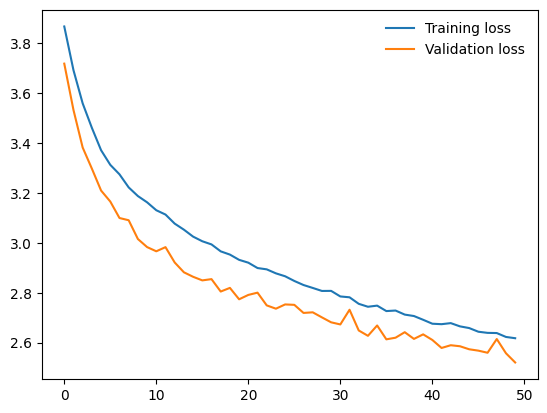

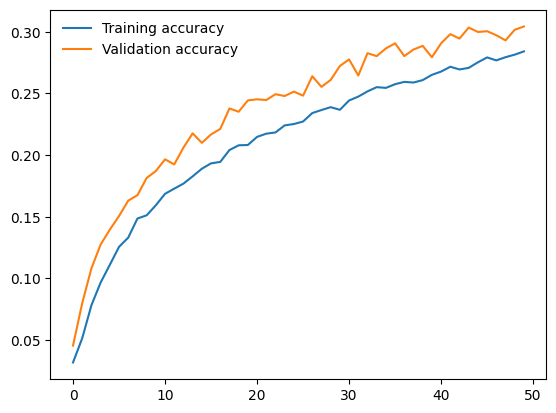

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/756b301020504b3a9808c7f7dab2804e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.0029243689049935715
COMET INFO:     test_accuracy   : 0.3383809030056
COMET INFO:     test_loss       : 2.3848788699370593
COMET INFO:     train_acc [50]  : (0.03172144293785095, 0.28412821888923645)
COMET INFO:     train_loss [50] : (2.6177396829255515, 3.866765475432307)
COMET INFO:     val_acc [50]    : (0.045427557080984116, 0.30433493852615356)
COMET INFO:     val_loss [50]   : (2.520538912249857, 3.7178664954994183)
COMET INFO:   Parameters:
COMET INFO:     backbone        : <function mobil

Test loss: 2.385.. 
Test accuracy: 0.338
Test Time: 0.0m 10s 42ms


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


(2.3848788699370593, tensor(0.3384, device='mps:0'))